<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/waves/CRLB_for_Two_Mode_Phase_Retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cramer-Rao Bound for Two-mode Phase Retrieval
*Timothy Schulz and David Brady*

## Python packages 
Python packages: 

In [5]:
import math
import numpy as np
import numpy.random as rand
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la 
import scipy.sparse as sp
from google.colab import files

## Cramer-Rao Bound for amplitude and phase
For two-mode phase retrieval, the two modes are represented as $A_1$ and $A_2 e^{j \theta}$, where $\theta$ is the phase difference between the modes. The modes are transformed by the $M \times 2$ linear sampling matrix ${\bf H}$ to provide the intermediate signal $\underline{y}$:

\begin{equation}
\underline{y} = {\bf H}
\left[
  \begin{array}{c}
  A_1 \\ A_2^{j\theta}
  \end{array}
\right].
\end{equation}

To assure that the sampling is passive, both of the eigenvalues for ${\bf H}^\dagger {\bf H}$ must be less than or equal to 1. The observable signal, then, is the intensity for $\underline{y}$:

\begin{equation}
I_m = |y_m|^2.
\end{equation}

When the observed data are limited by photon noise, the Fisher information for the unobserved parameters is evaluated as
\begin{equation}
J_{\lambda, \gamma} = \sum_{m=1}^M 
\frac{\partial I_m}{\partial \lambda}
\frac{\partial I_m}{\partial \gamma}
\frac{1}{I_m}
\end{equation}
where $\lambda$ and $\gamma$ correspond to pairs of the parameters $(A_1, A_2, \theta)$. For example, the Fisher information for $A_1$ and $\theta$ is
\begin{equation}
J_{A_1, \theta} = \sum_{m=1}^M 
\frac{\partial I_m}{\partial A_1}
\frac{\partial I_m}{\partial \theta}
\frac{1}{I_m}
\end{equation}
The Fisher-information matrix is
\begin{equation}
{\bf J} = 
\left[
  \begin{array}{ccc}
  J_{A_1,A_1} & J_{A_1,A_2} & J_{A_1,\theta} \\
  J_{A_2,A_1} & J_{A_2,A_2} & J_{A_2,\theta} \\
  J_{\theta,A_1} & J_{\theta,A_2} & J_{\theta,\theta}
  \end{array}
\right],
\end{equation}  
and the Cramer-Rao lower bound matrix is
\begin{equation}
{\bf C} = {\bf J}^{-1}.
\end{equation}

In [3]:

# Version: 2020_04_30 7:14 PM

def twoPointPhaseRetrievalCRLB(A1, A2, theta, H):
#
# twoPointPhaseRetrievalCRLB:
#   Python function to evaluate the Cramer-Rao Lower Bound for the
#   phase-retrieval problem with a specific observation matrix H.
#
# Usage:
#   CRLB = twoPointPhaseRetrievalCRLB(A1, A2, theta, H);
#
# Inputs:
#      A1: KxN array of amplitudes for the first element in the signal
#      A2: KxN array of amplitudes for the second element in the signal
#   theta: KxN array of phases for the signal
#       H: Mx2 observation matrix 
#
# Outputs:
#      CRLB.A1: KxN array of the CRLB for the amplitudes specified in A1
#      CRLB.A2: KxN array of the CRLB for the amplitudes specified in A2
#   CRLB.theta: KxN array of the CRLB for the phases specified in theta
#
  # verify that the sampling system is passive
  (w, v) = la.eig(H.conjugate().T.dot(H))
  if w.real.max() > 1.0001:
    print('Sampling systems is not passive!')
    return -1

  # determine the number of samples0
  M    = H.shape[0]

  # extract the sampling coefficients
  h1   = H[:,0]
  h2   = H[:,1]
  h1sq = np.power(np.abs(h1),2)
  h2sq = np.power(np.abs(h2),2)
  h12  = np.abs(h1*h2)
  phi  = np.angle(h2*np.conjugate(h1))

  # initialize the Fisher information elements
  # (because of symmetry, J12 = J21, etc.)
  J11 = np.zeros(np.shape(A1))
  J12 = np.zeros(np.shape(A1))
  J1t = np.zeros(np.shape(A1))
  J22 = np.zeros(np.shape(A1))
  J2t = np.zeros(np.shape(A1))
  Jtt = np.zeros(np.shape(A1))  

  # evaluate the Fisher information elements0
  for m in range(0,M):
    I    = np.power(A1,2)*h1sq[m] + np.power(A2,2)*h2sq[m] + \
           2*A1*A2*h12[m]*np.cos(theta + phi[m])
    dIk1 = 2*(A2*np.cos(theta + phi[m])*h12[m] + A1*h1sq[m])
    dIk2 = 2*(A1*np.cos(theta + phi[m])*h12[m] + A2*h2sq[m])
    dIkt = -2*A1*A2*h12[m]*np.sin(theta + phi[m])
    J11  = J11 + dIk1*dIk1/I
    J12  = J12 + dIk1*dIk2/I
    J1t  = J1t + dIk1*dIkt/I
    J22  = J22 + dIk2*dIk2/I
    J2t  = J2t + dIk2*dIkt/I
    Jtt  = Jtt + dIkt*dIkt/I

  # determine the CRLB elements for the parameters
  detJ = -(np.power(J1t,2)*J22) + 2*J12*J1t*J2t - \
         J11*np.power(J2t,2) - np.power(J12,2)*Jtt + J11*J22*Jtt
  class CRLB:
    A1    = (-np.power(J2t,2) + J22*Jtt)/detJ         
    A2    = (-np.power(J1t,2) + J11*Jtt)/detJ 
    theta = (-np.power(J12,2) + J11*J22)/detJ
  return CRLB

# Example: 6 element sampling

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

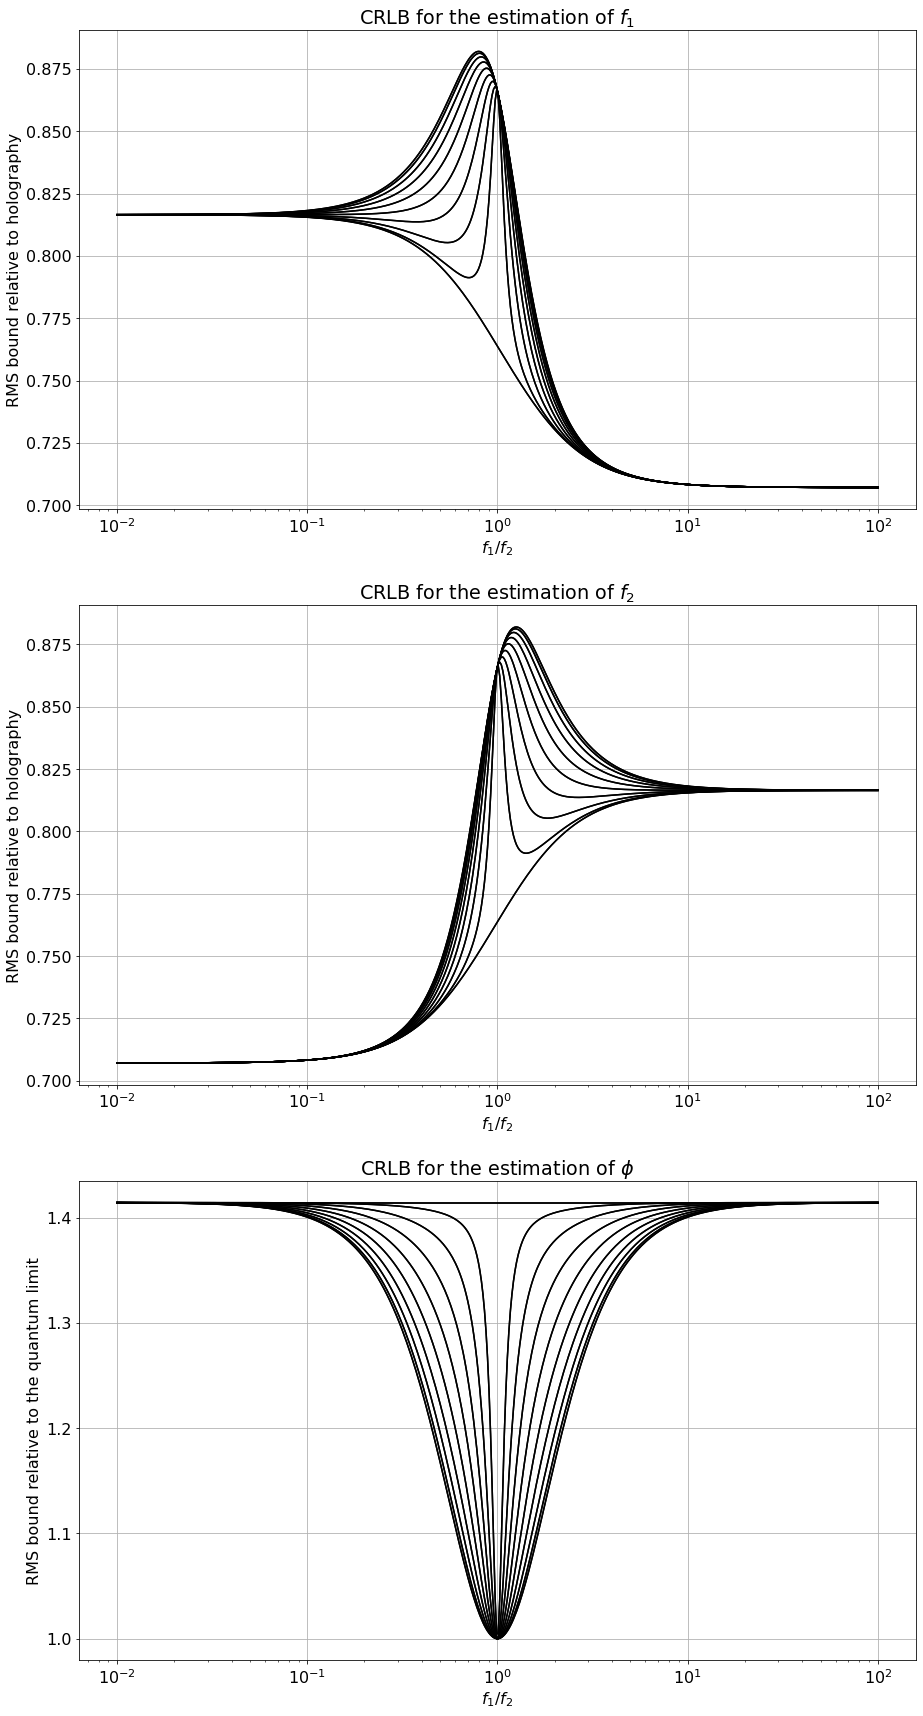

In [11]:
#
# sampling matrix
#
intenR=.5; # ratio of signal in pure intensity measurement
iSam=np.sqrt(1-intenR);
pSam=np.sqrt(intenR)/2;
H=np.array([[iSam,0], [0, iSam],[pSam, pSam],[pSam, -pSam],[pSam, 1j*pSam],[pSam, -1j*pSam]] )
#
# parameter values
#
abar         = 1
rho          = np.logspace(-2, 2, 500)
theta        = np.linspace(-math.pi, math.pi, 20)
[Rho, Theta] = np.meshgrid(rho, theta)
# 
# evaluate CRLBs
#
CRLB = twoPointPhaseRetrievalCRLB(abar*np.sqrt(Rho), \
                                  abar/np.sqrt(Rho), \
                                  Theta, H)

#
# plot the results
#
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [15,30]
plt.subplot(3,1,1)
plt.semilogx(rho, np.sqrt(CRLB.A1/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$f_1/f_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $f_1$')
plt.subplot(3,1,2)
plt.semilogx(rho, np.sqrt(CRLB.A2/(1/2)).T, 'k')
plt.grid()
plt.xlabel(r'$f_1/f_2$')
plt.ylabel('RMS bound relative to holography')
plt.title(r'CRLB for the estimation of $f_2$')
plt.subplot(3,1,3)
plt.semilogx(rho, np.sqrt(CRLB.theta/((Rho + 1/Rho)/2)).T, 'k')
plt.grid()
plt.xlabel(r'$f_1/f_2$')
plt.ylabel('RMS bound relative to the quantum limit')
plt.title(r'CRLB for the estimation of $\phi$')
plt.savefig('crlb2pPR.pdf')
files.download('crlb2pPR.pdf')